## Spam classifier

First, let's fetch the data:

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_hard_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [2]:
fetch_spam_data()

Next, let's load all the emails:

In [3]:
HAM_DIR = os.path.join(SPAM_PATH, "hard_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [4]:
len(ham_filenames)

250

In [5]:
len(spam_filenames)

500

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [6]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "hard_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [8]:
print(ham_emails[1].get_content().strip())

May 7, 2002


Dear rod-3ds@arsecandle.org:


Congratulations!  On behalf of Frito-Lay, Inc., we are pleased to advise you
 that you've won Fourth Prize in the 3D's(R) Malcolm in the Middle(TM)
 Sweepstakes.   Fourth Prize consists of 1 manufacturer's coupon redeemable at
 participating retailers for 1 free bag of 3D's(R) brand snacks (up to 7 oz.
 size), with an approximate retail value of $2.59 and an expiration date of
 12/31/02.

Follow these instructions to claim your prize:

1.	Print out this email message.

2.	Complete ALL of the information requested.  Print clearly and legibly.  Sign
 where indicated.

3.	If you are under 18 or otherwise under the legal age of majority in your
 state, your parent or legal guardian must co-sign where indicated below.

4.	Mail the completed and signed form to:  3D's(R) Malcolm in the Middle(TM)
 Sweepstakes, Redemption Center, PO Box 1520, Elmhurst IL 60126.  WE MUST
 RECEIVE THIS FORM NO LATER THAN MAY 28, 2002 IN ORDER TO SEND YOU THE PRIZE.

P

In [9]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [10]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [11]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [12]:
structures_counter(ham_emails).most_common()

[('text/html', 118),
 ('text/plain', 81),
 ('multipart(text/plain, text/html)', 43),
 ('multipart(text/html)', 2),
 ('multipart(text/plain, image/bmp)', 1),
 ('multipart(multipart(text/plain, text/html))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, image/png, image/png)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/jpeg, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif)',
  1),
 ('multipart(text/plain, text/plain)', 1)]

In [13]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [14]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [15]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-16-c6d32b215bf4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(ham_emails + spam_emails)


In [17]:
len(X_train)

600

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [18]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [19]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

Me and my friends have this brand new idea, a Live Webcam <a href="http://%31%30%31%31%30%31%31%31%30%31%31%31%31%30%31%30%31%30%31%30%31%30%31%31%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%31%30%31%30%31%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%31%30%30%30%31%30%31%31%30%31%31%31%30%31%30%31%30%31%30%31%30%31%30%30%30%31%31%30%31%30%31%30%31%31%30%31%30%31%30%31%30%31%31%30%31@%34%2E%34%37%2E%39%36%2E%31%34%31/msga.html"> Click Here <a/>
<br>
<br>
<br>
<font size="1">This is NOT SPAM - You have received this e-mail because 
at one time or another you entered the weekly draw at one of
our portals or FFA sites. We comply with all proposed and current laws 
on commercial e-mail under (Bill s. 1618 TITLE III passed by the 105th 
Congress).
 If you have received this e-mail in error, we apologize for the 
inconvenience and ask that you remove

And this is the resulting plain text:

In [20]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

Me and my friends have this brand new idea, a Live Webcam  HYPERLINK  Click Here
This is NOT SPAM - You have received this e-mail because
at one time or another you entered the weekly draw at one of
our portals or FFA sites. We comply with all proposed and current laws
on commercial e-mail under (Bill s. 1618 TITLE III passed by the 105th
Congress).
 If you have received this e-mail in error, we apologize for the
inconvenience and ask that you remove yourself.
Click   HYPERLINK Here to Unsubscribe
fysibvcgjyuwinmyvbpjtaebsymyukbrkn
 ...


Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [21]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [22]:
print(email_to_text(sample_html_spam)[:100], "...")

Me and my friends have this brand new idea, a Live Webcam  HYPERLINK  Click Here
This is NOT SPAM -  ...


Let's throw in some stemming! For this to work, you need to install the Natural Language Toolkit ([NLTK](http://www.nltk.org/)). It's as simple as running the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install nltk`

In [23]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install urlextract`

In [24]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [26]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'of': 30, 'to': 28, 'the': 28, 'and': 20, 'thi': 17, 'your': 14, 'in': 12, 'we': 12, 'a': 11, 'you': 11, 'number': 9, 'kabila': 9, 'congo': 8, 'countri': 8, 'is': 8, 'my': 8, 'us': 8, 'i': 7, 'presid': 7, 'assist': 6, 'out': 6, 'fund': 6, 'by': 5, 'laurent': 5, 'our': 5, 'as': 5, 'will': 5, 'with': 5, 'from': 4, 'col': 4, 'democrat': 4, 'republ': 4, 'code': 4, 'inform': 4, 'that': 4, 'money': 4, 'secur': 4, 'for': 4, 'be': 4, 'who': 4, 'move': 4, 'are': 4, 'linux': 4, 'michael': 3, 'bundu': 3, 'no': 3, 'intl': 3, 'access': 3, 'email': 3, 'immedi': 3, 'pleas': 3, 'me': 3, 'need': 3, 'one': 3, 'hi': 3, 'were': 3, 'late': 3, 'then': 3, 'other': 3, 'here': 3, 'can': 3, 'have': 3, 'contact': 3, 'confidenti': 3, 'not': 3, 'through': 3, 'work': 3, 'dial': 3, 'ie': 3, 'tel': 2, 'rediffmail': 2, 'com': 2, 'so': 2, 'trust': 2, 'foreign': 2, 'partner': 2, 'may': 2, 'but': 2, 'indulg': 2, 'view': 2, 'it': 2, 'name': 2, 'aid': 2, 'bless': 2, 'militari': 2, 'rebel': 2, 'some': 2, 'st

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [27]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [28]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [29]:
X_few_vectors.toarray()

array([[555,  30,  28,  12,  11,  20,  11,  28,   9,  14,  17],
       [699,  30,  24,  19,  14,  14,  21,  48,  29,   9,  16],
       [745,  13,  19,  10,  15,  17,  17,  21,  54,   9,   7]])

What does this matrix mean? Well, the 64 in the third row, first column, means that the third email contains 64 words that are not part of the vocabulary. The 1 next to it means that the first word in the vocabulary is present once in this email. The 2 next to it means that the second word is present twice, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "of", the second word is "and", etc.

In [29]:
vocab_transformer.vocabulary_

{'of': 1,
 'to': 2,
 'in': 3,
 'a': 4,
 'and': 5,
 'you': 6,
 'the': 7,
 'number': 8,
 'your': 9,
 'thi': 10}

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [30]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

## How to evaluate each classifier
- Using 5-fold cross validation:
 - Evaluate accuracy
 - Calculate the confusion matrix, precision, recall and f1-score
- Select some promising models
 - For models that implement decision_function() or predict_probas(),
  - Plot the precision vs recall curve
  - Plot ROC curve and calculate the ROC AUC
- Pick the classifier with best precision and recall

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def eval_confusion(y_pred, y_true=y_train):
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'matrix': conf_matrix, 'precision': precision, 'recall': recall, 'f1': f1}

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [33]:
import warnings

# stop scikit-learn's deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# classification models
sgd_clf = SGDClassifier(random_state=42, max_iter=500)
mlp_clf = MLPClassifier(hidden_layer_sizes=(16,))
tree_clf = DecisionTreeClassifier()
forest_clf = RandomForestClassifier()
adaboost_clf = AdaBoostClassifier()
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
log_clf = LogisticRegression(solver="liblinear", random_state=42)

classifiers = {
    'SGD': sgd_clf,
    'Decision Tree': tree_clf,
    'Random Forest': forest_clf,
    'AdaBoost': adaboost_clf,
    'KNN': knn_clf,
    'SVM': svm_clf,
    'MLP': mlp_clf,
    'LogisticRegression': log_clf
}

In [35]:
from sklearn.model_selection import cross_val_predict

# make predictions using each model
y_preds = {}
for clf_name, clf in classifiers.items():
    y_preds[clf_name] = cross_val_predict(clf, X_train_transformed, y_train, cv=5)

D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [36]:
from sklearn.metrics import accuracy_score

# evaluate each classifier's accuracy
for clf_name, y_pred in y_preds.items():
    print("{}:".format(clf_name))
    print(accuracy_score(y_train, y_pred))
    print()

SGD:
0.7716666666666666

Decision Tree:
0.8683333333333333

Random Forest:
0.92

AdaBoost:
0.93

KNN:
0.8783333333333333

SVM:
0.8416666666666667

MLP:
0.9333333333333333

LogisticRegression:
0.9333333333333333



## Promising models
- Logistic Regression 0.9333 
- Ada Boost 0.9300
- MLP 0.92
- Random Forest 0.916

In [37]:
# evaluate the confusion matrix, precision, recall and f1 score for each classifier
for clf_name, y_pred in y_preds.items():
    conf = eval_confusion(y_pred)
    print("{}:".format(clf_name))
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print()

SGD:
[[169  29]
 [108 294]]
precision: 0.9102167182662538
recall: 0.7313432835820896
f1-score: 0.8110344827586207

Decision Tree:
[[156  42]
 [ 37 365]]
precision: 0.8968058968058968
recall: 0.9079601990049752
f1-score: 0.9023485784919654

Random Forest:
[[158  40]
 [  8 394]]
precision: 0.9078341013824884
recall: 0.9800995024875622
f1-score: 0.9425837320574162

AdaBoost:
[[170  28]
 [ 14 388]]
precision: 0.9326923076923077
recall: 0.9651741293532339
f1-score: 0.9486552567237164

KNN:
[[151  47]
 [ 26 376]]
precision: 0.8888888888888888
recall: 0.9353233830845771
f1-score: 0.9115151515151514

SVM:
[[117  81]
 [ 14 388]]
precision: 0.8272921108742004
recall: 0.9651741293532339
f1-score: 0.8909299655568312

MLP:
[[166  32]
 [  8 394]]
precision: 0.9248826291079812
recall: 0.9800995024875622
f1-score: 0.9516908212560387

LogisticRegression:
[[167  31]
 [  9 393]]
precision: 0.9268867924528302
recall: 0.9776119402985075
f1-score: 0.9515738498789348



- SVM and SGD doesn't seem to be promising
- Best model so far is the MLP and LogisticRegression classifiers


In [38]:
from sklearn.model_selection import cross_val_predict

# calculate scores for each model
y_scores = {}
clf_thresholds = {}

for clf_name, clf in classifiers.items():
    method = 'predict_proba'
    if not hasattr(clf, 'predict_proba') and hasattr(clf, 'decision_function'):
        method = 'decision_function'
    y_scores[clf_name] = cross_val_predict(clf, X_train_transformed, y_train, cv=5,
                                           method=method)
    if method == 'predict_proba':
        y_scores[clf_name] = y_scores[clf_name][:,1]
        clf_thresholds[clf_name] = 0.5
    else:
        clf_thresholds[clf_name] = 0

D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
for clf_name, clf in classifiers.items():
    print("Classifier : {} , Thresholds: {}".format(clf_name,clf_thresholds[clf_name]))

Classifier : SGD , Thresholds: 0
Classifier : Decision Tree , Thresholds: 0.5
Classifier : Random Forest , Thresholds: 0.5
Classifier : AdaBoost , Thresholds: 0.5
Classifier : KNN , Thresholds: 0.5
Classifier : SVM , Thresholds: 0
Classifier : MLP , Thresholds: 0.5
Classifier : LogisticRegression , Thresholds: 0.5


In [40]:
from sklearn.metrics import precision_recall_curve

def plot_precision_vs_recall(y_scores, threshold=0, label=None, style='b-'):
    """plot precision vs recall for different thresholds, highlight the specified threshold"""
    
    # calculate scores and precisions and recalls at different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    
    # plot the precision and recall curves
    plt.plot(recalls, precisions, style, label=label)
    
    # highlight the threshold
    y_pred = y_scores >= threshold
    hl_precision = precision_score(y_train, y_pred)
    hl_recall = recall_score(y_train, y_pred)
    
    plt.plot([0, hl_recall], [hl_precision, hl_precision], 'r:')
    plt.plot([hl_recall, hl_recall], [0, hl_precision], 'r:')
    plt.plot([hl_recall], [hl_precision], 'ro')

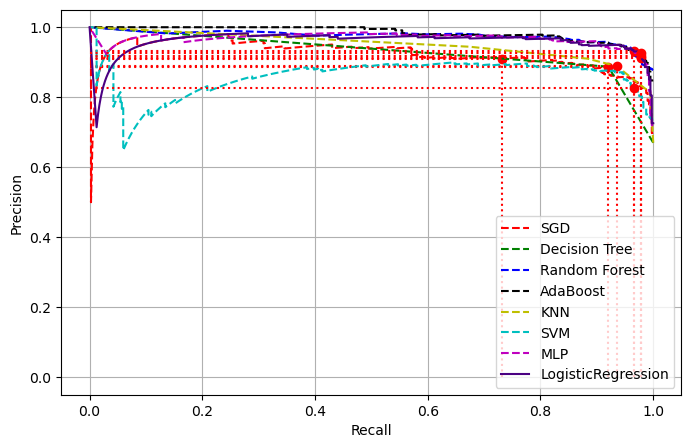

In [41]:
# plot recall vs precision for each model
mpl.style.use('default')
plt.figure(figsize=(8, 5))

styles = {
    'SGD': 'r--',
    'Decision Tree': 'g--',
    'Random Forest': 'b--',
    'AdaBoost': 'k--',
    'KNN': 'y--',
    'SVM': 'c--',
    'MLP': 'm--',
    'LogisticRegression':'indigo'
}

for clf_name, y_score in y_scores.items():
    plot_precision_vs_recall(y_score, threshold=clf_thresholds[clf_name], label=clf_name,
                             style=styles[clf_name])
    
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

In [42]:
from sklearn.metrics import roc_curve

def plot_roc(y_scores, threshold=0, label=None, style='b-'):
    """plot the ROC curve"""
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    # plot the ROC curve
    plt.plot(fpr, tpr, style, label=label)
    
    # false positive rate: false positives / true negatives + false positives
    # true positive rate (recall): true positives / (true positives + false negatives)
    # highlight the threshold
    y_pred = y_scores > threshold
    hl_fp = np.sum(np.logical_and(y_pred == True, y_train == 0))
    hl_tp = np.sum(np.logical_and(y_pred == True, y_train == 1))
    hl_fpr = hl_fp / np.sum(y_train == 0)
    hl_tpr = hl_tp / np.sum(y_train == 1)
    
    plt.plot([0, hl_fpr], [hl_tpr, hl_tpr], 'r:')
    plt.plot([hl_fpr, hl_fpr], [0, hl_tpr], 'r:')
    plt.plot([hl_fpr], [hl_tpr], 'ro')

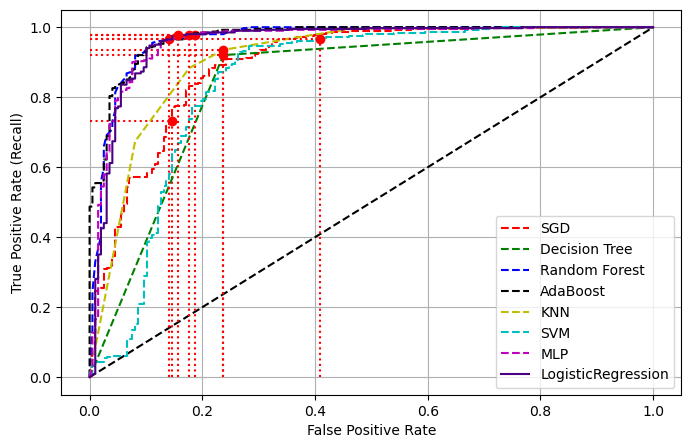

In [43]:
# plot ROC curve for each model
mpl.style.use('default')
plt.figure(figsize=(8, 5))

# ROC for purely random classifier
plt.plot([0, 1], [0, 1], 'k--')

for clf_name, y_score in y_scores.items():
    plot_roc(y_score, threshold=clf_thresholds[clf_name], label=clf_name, style=styles[clf_name])
    
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()

In [44]:
# calculate all ROC AUCs
from sklearn.metrics import roc_auc_score

print("ROC AUC scores:")
for clf_name, y_score in y_scores.items():
    roc_auc = roc_auc_score(y_train, y_score)
    print("- {}: {}".format(clf_name, roc_auc))

ROC AUC scores:
- SGD: 0.8952083019247199
- Decision Tree: 0.8415121362882556
- Random Forest: 0.9658839640182925
- AdaBoost: 0.9711543293632846
- KNN: 0.9106048042615206
- SVM: 0.8477938589878887
- MLP: 0.9589426604351977
- LogisticRegression: 0.9564927885823408


## Best classifiers to fine-tune:
- MLP
- LogisticRegression
- AdaBoost
- RandomForest

# Fine-tune the Best Classifiers

## To fine-tune each model:
- Use Grid Search or Random Search depending on the model type and use 5-fold CV
- Save each model to a file
- Evaluate the model on the test set

In [45]:
from sklearn.model_selection import GridSearchCV

# fine-tune MLP classifier
mlp_best = MLPClassifier()
mlp_param_grid = {
    'hidden_layer_sizes': [(16,), (16, 16), (32,),(32,32),(64,32,16)],
    'activation': ['relu', 'tanh', 'logistic']
}

mlp_grid_search = GridSearchCV(mlp_best, mlp_param_grid, 'f1', cv=5, verbose=2)
mlp_grid_search.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........activation=relu, hidden_layer_sizes=(16,); total time=   0.9s
[CV] END ..........activation=relu, hidden_layer_sizes=(16,); total time=   0.6s
[CV] END ..........activation=relu, hidden_layer_sizes=(16,); total time=   0.7s
[CV] END ..........activation=relu, hidden_layer_sizes=(16,); total time=   0.6s
[CV] END ..........activation=relu, hidden_layer_sizes=(16,); total time=   0.8s
[CV] END .......activation=relu, hidden_layer_sizes=(16, 16); total time=   0.8s
[CV] END .......activation=relu, hidden_layer_sizes=(16, 16); total time=   0.6s
[CV] END .......activation=relu, hidden_layer_sizes=(16, 16); total time=   0.6s
[CV] END .......activation=relu, hidden_layer_sizes=(16, 16); total time=   0.8s
[CV] END .......activation=relu, hidden_layer_sizes=(16, 16); total time=   0.8s
[CV] END ..........activation=relu, hidden_layer_sizes=(32,); total time=   0.8s
[CV] END ..........activation=relu, hidden_layer_sizes=(32,); total time=   0.9s
[CV] END ..........activatio

D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........activation=tanh, hidden_layer_sizes=(16,); total time=   0.9s
[CV] END ..........activation=tanh, hidden_layer_sizes=(16,); total time=   0.7s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........activation=tanh, hidden_layer_sizes=(16,); total time=   0.9s
[CV] END .......activation=tanh, hidden_layer_sizes=(16, 16); total time=   0.8s
[CV] END .......activation=tanh, hidden_layer_sizes=(16, 16); total time=   1.0s
[CV] END .......activation=tanh, hidden_layer_sizes=(16, 16); total time=   1.1s
[CV] END .......activation=tanh, hidden_layer_sizes=(16, 16); total time=   0.7s
[CV] END .......activation=tanh, hidden_layer_sizes=(16, 16); total time=   0.8s
[CV] END ..........activation=tanh, hidden_layer_sizes=(32,); total time=   0.9s
[CV] END ..........activation=tanh, hidden_layer_sizes=(32,); total time=   1.0s
[CV] END ..........activation=tanh, hidden_layer_sizes=(32,); total time=   0.9s
[CV] END ..........activation=tanh, hidden_layer_sizes=(32,); total time=   0.8s
[CV] END ..........activation=tanh, hidden_layer_sizes=(32,); total time=   1.2s
[CV] END .......activation=tanh, hidden_layer_sizes=(32, 32); total time=   1.2s
[CV] END .......activation=t

D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(16,); total time=   1.0s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(16,); total time=   1.2s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(16,); total time=   1.3s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(16,); total time=   0.9s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(16,); total time=   0.9s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...activation=logistic, hidden_layer_sizes=(16, 16); total time=   1.0s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...activation=logistic, hidden_layer_sizes=(16, 16); total time=   1.1s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...activation=logistic, hidden_layer_sizes=(16, 16); total time=   1.0s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...activation=logistic, hidden_layer_sizes=(16, 16); total time=   1.0s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...activation=logistic, hidden_layer_sizes=(16, 16); total time=   1.1s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(32,); total time=   1.3s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(32,); total time=   1.6s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(32,); total time=   1.3s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(32,); total time=   1.3s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ......activation=logistic, hidden_layer_sizes=(32,); total time=   1.4s
[CV] END ...activation=logistic, hidden_layer_sizes=(32, 32); total time=   1.4s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...activation=logistic, hidden_layer_sizes=(32, 32); total time=   1.5s
[CV] END ...activation=logistic, hidden_layer_sizes=(32, 32); total time=   1.5s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...activation=logistic, hidden_layer_sizes=(32, 32); total time=   1.5s
[CV] END ...activation=logistic, hidden_layer_sizes=(32, 32); total time=   1.5s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(64, 32, 16); total time=   2.8s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(64, 32, 16); total time=   2.7s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(64, 32, 16); total time=   2.7s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(64, 32, 16); total time=   2.8s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(64, 32, 16); total time=   2.7s


GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(16,), (16, 16), (32,),
                                                (32, 32), (64, 32, 16)]},
             scoring='f1', verbose=2)

In [46]:
# fine-tune AdaBoost classifier
adaboost_best = AdaBoostClassifier()
adaboost_param_grid = {
    'n_estimators': [10, 30, 50, 100],
    'learning_rate':[0.01,0.1,1,10]
}

adaboost_grid_search = GridSearchCV(adaboost_best, adaboost_param_grid, 'f1', cv=5, verbose=2)
adaboost_grid_search.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ................learning_rate=0.01, n_estimators=10; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=10; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=10; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=10; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=10; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END ................learning_rate=0.01, n_e

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'n_estimators': [10, 30, 50, 100]},
             scoring='f1', verbose=2)

In [47]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

# fine-tune SVM classifier
logistic_best = LogisticRegression()
logistic_param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': scipy.stats.reciprocal(20, 200000),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

logistic_randomized_search = RandomizedSearchCV(logistic_best, logistic_param_dist, n_iter=5, scoring='f1',
                                           cv=5, verbose=2, random_state=42)
logistic_randomized_search.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...C=629.782329591372, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=629.782329591372, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=629.782329591372, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=629.782329591372, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=629.782329591372, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=26290.206464300216, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=26290.206464300216, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=26290.206464300216, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=26290.206464300216, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=26290.206464300216, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=84.14107900575871, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=84.14107900575871, penalty=elast

D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\ProgramData\An

[CV] END ........C=24.17508294611391, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........C=24.17508294611391, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........C=24.17508294611391, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........C=24.17508294611391, penalty=l2, solver=sag; total time=   0.0s


D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\ProgramData\Anaconda3\envs\Bitirme\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9412285         nan        nan        nan 0.77791927]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=5,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020DAE0CC9D0>,
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='f1', verbose=2)

In [48]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

# fine-tune SVM classifier
random_best = RandomForestClassifier()
random_param_dist = {
    'n_estimators': [10,100,1000],
    'criterion': ['gini', 'entropy'],
}

random_randomized_search = RandomizedSearchCV(random_best, random_param_dist, n_iter=5, scoring='f1',
                                           cv=5, verbose=2, random_state=42)
random_randomized_search.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ....................criterion=gini, n_estimators=10; total time=   0.0s
[CV] END ....................criterion=gini, n_estimators=10; total time=   0.0s
[CV] END ....................criterion=gini, n_estimators=10; total time=   0.0s
[CV] END ....................criterion=gini, n_estimators=10; total time=   0.0s
[CV] END ....................criterion=gini, n_estimators=10; total time=   0.0s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.2s
[CV] END ...............criterion=entropy, n_estimators=1000; total time=   2.8s
[CV] END ...............criterion=entropy, n_esti

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'n_estimators': [10, 100, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [49]:
import joblib

def save_model(model, filename):
    # create directory if it doesn't exist
    if not os.path.isdir(MODELS_DIR):
        os.makedirs(MODELS_DIR)
        
    path = os.path.join(MODELS_DIR, filename)
    joblib.dump(model, path)

In [50]:
# get the best estimators
mlp_best = mlp_grid_search.best_estimator_
adaboost_best = adaboost_grid_search.best_estimator_
logistic_best = logistic_randomized_search.best_estimator_
random_best =  random_randomized_search.best_estimator_
MODELS_DIR = 'models'
# save each model
save_model(mlp_best, 'mlp_best.pkl')
save_model(adaboost_best, 'adaboost_best.pkl')
save_model(logistic_best, 'logistic_best.pkl')
save_model(random_best, 'random_best.pkl')

In [51]:
mlp_grid_search.best_estimator_

MLPClassifier(activation='tanh', hidden_layer_sizes=(16, 16))

In [52]:
adaboost_grid_search.best_estimator_

AdaBoostClassifier(learning_rate=1, n_estimators=100)

In [53]:
logistic_randomized_search.best_estimator_

LogisticRegression(C=629.782329591372, penalty='l1', solver='liblinear')

In [54]:
random_randomized_search.best_estimator_

RandomForestClassifier(criterion='entropy')

In [55]:
# evaluate each model on the training set
best_clf = {
    'MLP': mlp_best,
    'AdaBoost': adaboost_best,
    'LogisticRegression': logistic_best,
    'RandomForestClassifier' : random_best
}

for clf_name, clf in best_clf.items():
    y_pred = clf.predict(X_train_transformed)
    conf = eval_confusion(y_pred, y_train)
    print("{}:".format(clf_name))
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_train)))
    print()

MLP:
[[198   0]
 [  0 402]]
precision: 1.0
recall: 1.0
f1-score: 1.0
accuracy: 1.0

AdaBoost:
[[198   0]
 [  0 402]]
precision: 1.0
recall: 1.0
f1-score: 1.0
accuracy: 1.0

LogisticRegression:
[[198   0]
 [  0 402]]
precision: 1.0
recall: 1.0
f1-score: 1.0
accuracy: 1.0

RandomForestClassifier:
[[198   0]
 [  0 402]]
precision: 1.0
recall: 1.0
f1-score: 1.0
accuracy: 1.0



In [56]:
# prepare the test dataset
X_test_prepared = preprocess_pipeline.transform(X_test)

# evaluate each model on the test set
for clf_name, clf in best_clf.items():
    y_pred = clf.predict(X_test_prepared)
    conf = eval_confusion(y_pred, y_test)
    print("{}:".format(clf_name))
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_test)))
    print()
    

MLP:
[[46  6]
 [ 2 96]]
precision: 0.9411764705882353
recall: 0.9795918367346939
f1-score: 0.96
accuracy: 0.9466666666666667

AdaBoost:
[[46  6]
 [ 1 97]]
precision: 0.941747572815534
recall: 0.9897959183673469
f1-score: 0.9651741293532338
accuracy: 0.9533333333333334

LogisticRegression:
[[43  9]
 [ 4 94]]
precision: 0.912621359223301
recall: 0.9591836734693877
f1-score: 0.9353233830845772
accuracy: 0.9133333333333333

RandomForestClassifier:
[[42 10]
 [ 1 97]]
precision: 0.9065420560747663
recall: 0.9897959183673469
f1-score: 0.9463414634146342
accuracy: 0.9266666666666666



The Best Classifier is the AdaBoost Classifier with about : 
- 95.53% accuracy
- 94.17% precision
- 98.97% recall
- 94.17% f1-score